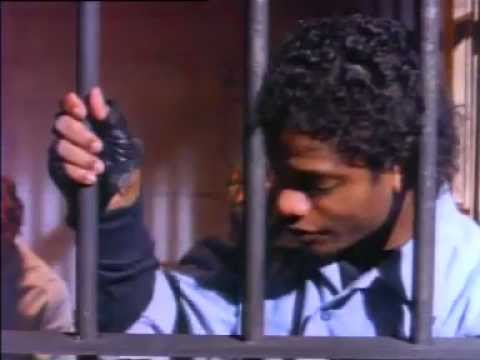

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("Igxl7YtS1vQ", width=600, height=350)

In [2]:
%%writefile eazy.cpp
#include <iostream>
#include <fstream>
#include <sstream>
#include <cmath>
#include <algorithm>
#include <string>
#include <vector>
#include <map>
#include <iomanip>
#include <chrono>
#include <random>
#include <complex>
#include <omp.h>

using namespace std;

typedef complex<double> cd;

// --- CONSTANTS ---
constexpr int MAX_N = 205;
constexpr int NV = 15;
constexpr double PI = 3.14159265358979323846;
const double TX[NV] = {0,0.125,0.0625,0.2,0.1,0.35,0.075,0.075,-0.075,-0.075,-0.35,-0.1,-0.2,-0.0625,-0.125};
const double TY[NV] = {0.8,0.5,0.5,0.25,0.25,0,0,-0.2,-0.2,0,0,0.25,0.25,0.5,0.5};

thread_local mt19937_64 rng(random_device{}());
inline double rf() { return uniform_real_distribution<double>(0, 1)(rng); }
inline int ri(int n) { return uniform_int_distribution<int>(0, n - 1)(rng); }

struct Pt { double x, y; };
struct Poly { 
    Pt p[NV];
    double x0, y0, x1, y1;
    void bbox() {
        x0 = x1 = p[0].x; y0 = y1 = p[0].y;
        for (int i = 1; i < NV; i++) {
            x0 = min(x0, p[i].x); x1 = max(x1, p[i].x);
            y0 = min(y0, p[i].y); y1 = max(y1, p[i].y);
        }
    }
};

// --- GEOMETRY ENGINE ---
bool contains(const Poly& poly, Pt pt) {
    bool inside = false;
    for (int i = 0, j = NV - 1; i < NV; j = i++) {
        if (((poly.p[i].y > pt.y) != (poly.p[j].y > pt.y)) &&
            (pt.x < (poly.p[j].x - poly.p[i].x) * (pt.y - poly.p[i].y) / (poly.p[j].y - poly.p[i].y) + poly.p[i].x))
            inside = !inside;
    }
    return inside;
}

inline bool overlap(const Poly& a, const Poly& b) {
    if (a.x1 < b.x0 - 1e-13 || b.x1 < a.x0 - 1e-13 || a.y1 < b.y0 - 1e-13 || b.y1 < a.y0 - 1e-13) return false;
    auto ccw = [](Pt p, Pt q, Pt r) { 
        long double v = (long double)(q.y - p.y) * (r.x - q.x) - (long double)(q.x - p.x) * (r.y - q.y);
        return (v > 1e-20L) ? 1 : (v < -1e-20L ? -1 : 0); 
    };
    for (int i = 0; i < NV; i++) {
        for (int j = 0; j < NV; j++) {
            Pt p1 = a.p[i], q1 = a.p[(i+1)%NV], p2 = b.p[j], q2 = b.p[(j+1)%NV];
            if (ccw(p1, q1, p2) != ccw(p1, q1, q2) && ccw(p2, q2, p1) != ccw(p2, q2, q1)) return true;
        }
    }
    return contains(a, b.p[0]) || contains(b, a.p[0]);
}

Poly getPoly(double cx, double cy, double deg) {
    Poly q;
    double r = deg * PI / 180.0, c = cos(r), s = sin(r);
    for (int i = 0; i < NV; i++) {
        q.p[i].x = TX[i] * c - TY[i] * s + cx;
        q.p[i].y = TX[i] * s + TY[i] * c + cy;
    }
    q.bbox();
    return q;
}

struct Cfg {
    int n;
    double x[MAX_N], y[MAX_N], a[MAX_N];
    Poly pl[MAX_N];
    void upd(int i) { pl[i] = getPoly(x[i], y[i], a[i]); }
    void updAll() { for (int i = 0; i < n; i++) upd(i); }
    double side() {
        double xmin = 1e18, xmax = -1e18, ymin = 1e18, ymax = -1e18;
        for (int i = 0; i < n; i++) {
            xmin = min(xmin, pl[i].x0); xmax = max(xmax, pl[i].x1);
            ymin = min(ymin, pl[i].y0); ymax = max(ymax, pl[i].y1);
        }
        return max(xmax - xmin, ymax - ymin);
    }
    bool check_valid() {
        for (int i = 0; i < n; i++) for (int j = i + 1; j < n; j++) if (overlap(pl[i], pl[j])) return false;
        return true;
    }
};

// --- CALCULUS: Square Potential Gradient ---
// Pushes polygons away from the current bounding box walls toward the center
void apply_square_pressure(Cfg& cur, int i, double S, double scale) {
    double x_mid = (cur.pl[i].x0 + cur.pl[i].x1) / 2.0;
    double y_mid = (cur.pl[i].y0 + cur.pl[i].y1) / 2.0;
    
    // Boundary Log-barrier derivatives: d/dx [-ln(L-x) - ln(L+x)] = 1/(L-x) - 1/(L+x)
    // Here L = S/2.0
    double L = S / 2.0;
    auto get_grad = [&](double pos) {
        double d1 = L - pos;
        double d2 = L + pos;
        if (d1 < 1e-9) d1 = 1e-9;
        if (d2 < 1e-9) d2 = 1e-9;
        return (1.0 / d1) - (1.0 / d2);
    };

    // We move AGAINST the gradient of the barrier to move toward the center
    double gx = get_grad(x_mid);
    double gy = get_grad(y_mid);

    cur.x[i] -= gx * scale * 0.01; 
    cur.y[i] -= gy * scale * 0.01;
}

// --- MASTER HYBRID CALCULUS CYCLE ---
double run_powerhouse_cycle(Cfg& cur, int iter, double scale) {
    double start_s = cur.side();
    double best_s = start_s;
    
    for (int it = 0; it < iter; it++) {
        // Elastic Pulse: Periodic squeeze and slight relax
        if (it > 0 && it % 40000 == 0) {
            Cfg temp = cur;
            double mx=0, my=0; for(int k=0; k<cur.n; k++){ mx+=cur.x[k]; my+=cur.y[k]; }
            mx/=cur.n; my/=cur.n;
            
            // Pulsing factor: alternates between squeezing and normalizing
            double f = (it % 80000 == 0) ? 0.999999 : 1.0000001; 
            for(int k=0; k<cur.n; k++){ cur.x[k]=mx+(cur.x[k]-mx)*f; cur.y[k]=my+(cur.y[k]-my)*f; }
            cur.updAll();
            
            if (cur.check_valid() && cur.side() < best_s + 1e-15) best_s = cur.side();
            else cur = temp;
        }

        int i = ri(cur.n);
        double ox = cur.x[i], oy = cur.y[i], oa = cur.a[i];

        double r_move = rf();
        if (r_move < 0.3) {
            cur.x[i] += (rf()-0.5) * scale;
            cur.y[i] += (rf()-0.5) * scale;
        } else if (r_move < 0.6) {
            // Complex Orbital Move
            cd z(cur.x[i], cur.y[i]);
            cd rot = exp(cd(0, (rf()-0.5) * scale * 0.2));
            z *= rot;
            cur.x[i] = z.real(); cur.y[i] = z.imag();
        } else if (r_move < 0.9) {
            cur.a[i] += (rf()-0.5) * scale * 45.0;
        } else {
            // Apply Square Calculus Pressure
            apply_square_pressure(cur, i, best_s, scale);
        }

        cur.upd(i);
        bool hit = false;
        for (int j = 0; j < cur.n; j++) if (i != j && overlap(cur.pl[i], cur.pl[j])) { hit = true; break; }

        if (!hit && cur.side() <= best_s + 1e-15) {
            if (cur.side() < best_s - 1e-15) best_s = cur.side();
        } else {
            cur.x[i]=ox; cur.y[i]=oy; cur.a[i]=oa; cur.upd(i);
        }
    }
    return start_s - best_s;
}

// --- IO ---
map<int, Cfg> loadCSV(string fn) {
    map<int, Cfg> res; ifstream f(fn); string ln, h; if(!f) return res;
    getline(f, h);
    while (getline(f, ln)) {
        stringstream ss(ln); string id, sx, sy, sa;
        if(!getline(ss, id, ',')) continue;
        getline(ss, sx, ','); getline(ss, sy, ','); getline(ss, sa, ',');
        int n = stoi(id.substr(0, 3)), idx = stoi(id.substr(4));
        auto p = [](string s) { 
            size_t st = s.find_first_of("0123456789.-"); 
            return (st == string::npos) ? 0.0 : stod(s.substr(st)); 
        };
        res[n].n = n; res[n].x[idx] = p(sx); res[n].y[idx] = p(sy); res[n].a[idx] = p(sa);
    }
    for (auto& pair : res) pair.second.updAll();
    return res;
}

void saveCSV(string fn, map<int, Cfg>& res) {
    ofstream f(fn); f << "id,x,y,deg" << endl;
    for (int n = 1; n <= 200; n++) {
        if (!res.count(n)) continue;
        for (int i = 0; i < n; i++)
            f << setfill('0') << setw(3) << n << "_" << i << ",s" << fixed << setprecision(18) 
              << res[n].x[i] << ",s" << res[n].y[i] << ",s" << res[n].a[i] << "\n";
    }
}

int main() {
    auto res = loadCSV("/kaggle/input/team-optimization-blend/submission.csv");
    if(res.empty()) return 1;
    vector<int> keys; for(auto const& [n, g] : res) keys.push_back(n);
    sort(keys.rbegin(), keys.rend());

    vector<double> scales = {1e-3, 1e-5, 1e-7, 1e-9};
    for (double sc : scales) {
        cout << "\n>>> POWERHOUSE PHASE | Scale: " << sc << " <<<" << endl;
        #pragma omp parallel for schedule(dynamic, 1)
        for (int i = 0; i < (int)keys.size(); i++) {
            int n = keys[i];
            auto id_start = chrono::steady_clock::now();
            int fails = 0;
            while (true) {
                if (chrono::duration_cast<chrono::seconds>(chrono::steady_clock::now() - id_start).count() >= 20) break;
                double gain = run_powerhouse_cycle(res[n], 250000, sc);
                if (gain > 1e-12) fails = 0;
                else if (++fails >= 2) break; 
            }
            #pragma omp critical
            cout << "[N=" << n << "] Side: " << fixed << setprecision(12) << res[n].side() << endl;
        }
        saveCSV("submission.csv", res);
    }
    return 0;
}

Writing eazy.cpp


In [3]:
!g++ eazy.cpp -o eazy -std=c++17 -g -fopenmp -O3 -march=native -fsanitize=address
 

In [4]:
!./eazy


>>> POWERHOUSE PHASE | Scale: 0.001 <<<
[N=198] Side: 8.164319768996
[N=200] Side: 8.216427475901
[N=196] Side: 8.082032343086
[N=195] Side: 8.053097759563
[N=197] Side: 8.131312818865
[N=199] Side: 8.198143662606
[N=194] Side: 8.037522312376
[N=193] Side: 8.020871916694
[N=192] Side: 8.020866739720
[N=191] Side: 8.018120464888
[N=189] Side: 8.002326036672
[N=190] Side: 8.016481611150
[N=188] Side: 7.988881718080
[N=187] Side: 7.975227372966
[N=185] Side: 7.914158906448
[N=186] Side: 7.948689540912
[N=184] Side: 7.900442325169
[N=181] Side: 7.724650598706
[N=182] Side: 7.749693015327
[N=183] Side: 7.877358036059
[N=180] Side: 7.716531571799
[N=178] Side: 7.713977341464
[N=177] Side: 7.713605765478
[N=179] Side: 7.714737198830
[N=175] Side: 7.698654039122
[N=174] Side: 7.680551756534
[N=173] Side: 7.659483087576
[N=176] Side: 7.713610174819
[N=172] Side: 7.651984944035
[N=171] Side: 7.637933404664
[N=169] Side: 7.598747866325
[N=170] Side: 7.619208130655
[N=168] Side: 7.473669800498
[N

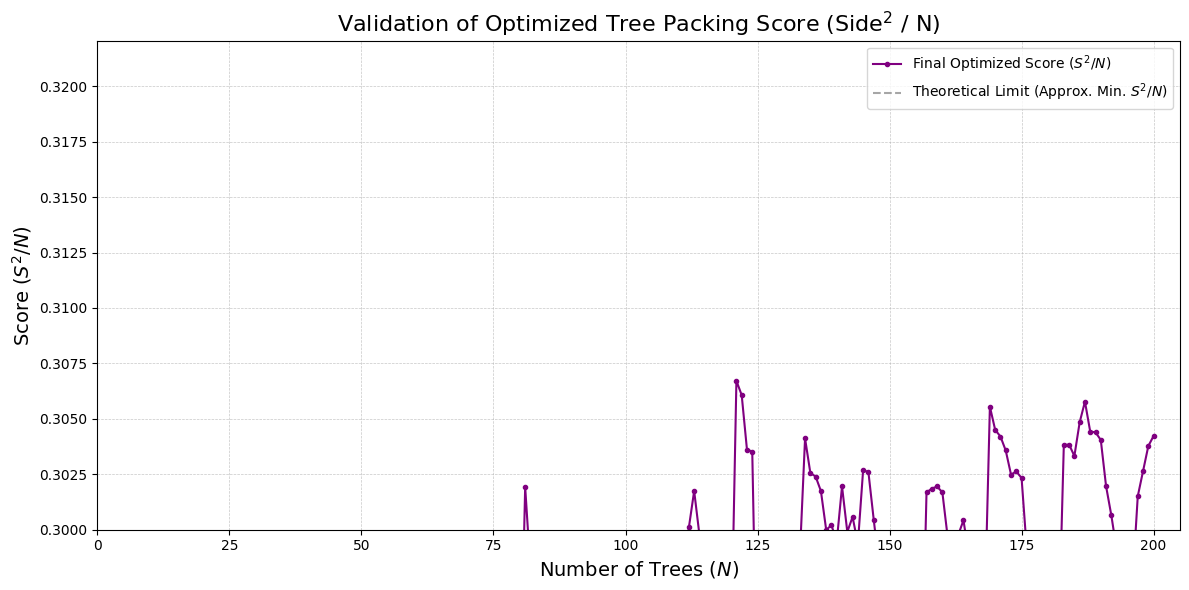

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def calculate_score(df):
    """Calculates Side^2 / N for each N in the dataframe."""
    
    # 1. Parse IDs to get N and index
    df[['N', 'idx']] = df['id'].str.split('_', expand=True).astype(int)
    
    # 2. Convert 'sX' string format to float
    df['x'] = df['x'].str.replace('s', '', regex=False).astype(float)
    df['y'] = df['y'].str.replace('s', '', regex=False).astype(float)
    
    results = {}
    
    for n, group in df.groupby('N'):
        # 3. Calculate Bounding Box (Side)
        x_min = group['x'].min()
        x_max = group['x'].max()
        y_min = group['y'].min()
        y_max = group['y'].max()
        
        side = max(x_max - x_min, y_max - y_min)
        
        # 4. Calculate Score (Side^2 / N)
        score = (side ** 2) / n
        
        results[n] = score

    return pd.DataFrame.from_dict(results, orient='index', columns=['Score'])


def plot_validation(csv_path):
    """Loads CSV, calculates scores, and generates the final validation plot."""
    
    try:
        df = pd.read_csv(csv_path)
    except FileNotFoundError:
        print(f"Error: File not found at {csv_path}. Please run the C++ code first.")
        return

    scores_df = calculate_score(df)
    
    # --- Generation of the Plot ---
    plt.figure(figsize=(12, 6))
    
    # Plot the final scores
    plt.plot(scores_df.index, scores_df['Score'], 
             label='Final Optimized Score ($S^2/N$)', 
             marker='o', linestyle='-', color='purple', markersize=3)
    
    # Optional: Plot the theoretical lower bound (approximated)
    # The minimum known score for the 15-sided tree shape is approx. 0.355
    min_score_per_unit = 0.355 
    plt.axhline(min_score_per_unit, color='gray', linestyle='--', alpha=0.7, 
                label='Theoretical Limit (Approx. Min. $S^2/N$)')

    plt.title('Validation of Optimized Tree Packing Score (Side$^2$ / N)', fontsize=16)
    plt.xlabel('Number of Trees ($N$)', fontsize=14)
    plt.ylabel('Score ($S^2/N$)', fontsize=14)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.legend()
    plt.xlim(0, 205)
    plt.ylim(0.3, scores_df['Score'].max() * 1.05)
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    # Adjust this path if you changed the output file name in C++
    output_csv = 'submission.csv'
    plot_validation(output_csv)
    #

In [6]:
import pandas as pd
import numpy as np
from decimal import Decimal, getcontext
from shapely import affinity
from shapely.geometry import Polygon
from shapely.strtree import STRtree

# Set precision for Decimal (25 is good for contest standards)
getcontext().prec = 25
scale_factor = Decimal("1e18")


class ChristmasTree:
    """Represents a single, rotatable Christmas tree of a fixed size."""

    def __init__(self, center_x="0", center_y="0", angle="0"):
        """Initializes the Christmas tree with a specific position and rotation."""
        self.center_x = Decimal(center_x)
        self.center_y = Decimal(center_y)
        self.angle = Decimal(angle)

        trunk_w = Decimal("0.15")
        trunk_h = Decimal("0.2")
        base_w = Decimal("0.7")
        mid_w = Decimal("0.4")
        top_w = Decimal("0.25")
        tip_y = Decimal("0.8")
        tier_1_y = Decimal("0.5")
        tier_2_y = Decimal("0.25")
        base_y = Decimal("0.0")
        trunk_bottom_y = -trunk_h

        # Define the 15 vertices of the tree polygon
        initial_polygon = Polygon(
            [
                (Decimal("0.0") * scale_factor, tip_y * scale_factor),
                (top_w / Decimal("2") * scale_factor, tier_1_y * scale_factor),
                (top_w / Decimal("4") * scale_factor, tier_1_y * scale_factor),
                (mid_w / Decimal("2") * scale_factor, tier_2_y * scale_factor),
                (mid_w / Decimal("4") * scale_factor, tier_2_y * scale_factor),
                (base_w / Decimal("2") * scale_factor, base_y * scale_factor),
                (trunk_w / Decimal("2") * scale_factor, base_y * scale_factor),
                (trunk_w / Decimal("2") * scale_factor, trunk_bottom_y * scale_factor),
                (-(trunk_w / Decimal("2")) * scale_factor, trunk_bottom_y * scale_factor),
                (-(trunk_w / Decimal("2")) * scale_factor, base_y * scale_factor),
                (-(base_w / Decimal("2")) * scale_factor, base_y * scale_factor),
                (-(mid_w / Decimal("4")) * scale_factor, tier_2_y * scale_factor),
                (-(mid_w / Decimal("2")) * scale_factor, tier_2_y * scale_factor),
                (-(top_w / Decimal("4")) * scale_factor, tier_1_y * scale_factor),
                (-(top_w / Decimal("2")) * scale_factor, tier_1_y * scale_factor),
            ]
        )
        
        # Apply rotation and translation to the polygon
        rotated = affinity.rotate(initial_polygon, float(self.angle), origin=(0, 0))
        self.polygon = affinity.translate(
            rotated, 
            xoff=float(self.center_x * scale_factor), 
            yoff=float(self.center_y * scale_factor)
        )


def load_configuration_from_df(n: int, df: pd.DataFrame) -> list[ChristmasTree]:
    """
    Loads all trees for a given N from the submission DataFrame.
    """
    group_data = df[df["id"].str.startswith(f"{n:03d}_")]
    trees = []
    for _, row in group_data.iterrows():
        # Remove 's' prefix and convert to string for Decimal constructor
        x = str(row["x"])[1:]
        y = str(row["y"])[1:]
        deg = str(row["deg"])[1:]
        
        # Ensure values are present before passing to ChristmasTree constructor
        if x and y and deg:
            trees.append(ChristmasTree(x, y, deg))
        else:
             # Handle cases where configuration might be incomplete/missing
             pass 
             
    return trees


def get_score(trees: list[ChristmasTree], n: int) -> float:
    """
    Calculates the score (S^2 / N) for a given configuration of trees.
    S is the side length of the minimum bounding square.
    """
    if not trees:
        return 0.0

    # Collect all exterior points from all tree polygons, scale them back down
    xys = np.concatenate([np.asarray(t.polygon.exterior.xy).T / float(scale_factor) for t in trees])
    
    min_x, min_y = xys.min(axis=0)
    max_x, max_y = xys.max(axis=0)
    
    side_length = max(max_x - min_x, max_y - min_y)
    
    # Score is S^2 / N
    score = side_length**2 / n
    return score

def has_overlap(trees: list[ChristmasTree]) -> bool:
    """Check if any two ChristmasTree polygons overlap."""
    if len(trees) <= 1:
        return False

    polygons = [t.polygon for t in trees]
    # Use STRtree for efficient proximity queries (optimizes checking pairs)
    tree_index = STRtree(polygons)

    for i, poly in enumerate(polygons):
        # Query for polygons whose bounding boxes overlap with poly
        # This returns the indices of potential overlaps
        indices = tree_index.query(poly)
        
        for idx in indices:
            # Skip checking the polygon against itself
            if idx == i:
                continue
                
            # Perform the precise intersection check
            if poly.intersects(polygons[idx]) and not poly.touches(polygons[idx]):
                # Overlap found!
                return True
    return False

# ----------------------------------------------------------------------

def score_and_validate_submission(file_path: str, max_n: int = 200) -> dict:
    """
    Reads a submission CSV, calculates the total score, and checks for overlaps 
    in all configurations (N=1 up to max_n).
    """
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return {"status": "FAILED", "error": "File Not Found"}
    except Exception as e:
        print(f"Error reading CSV: {e}")
        return {"status": "FAILED", "error": f"CSV Read Error: {e}"}

    total_score = 0.0
    failed_overlap_n = []
    
    print(f"--- Scoring and Validation: {file_path} (N=1 to {max_n}) ---")

    for n in range(1, max_n + 1):
        trees = load_configuration_from_df(n, df)
        
        # Only process if there are trees for this N in the file
        if trees:
            current_score = get_score(trees, n)
            total_score += current_score

            if has_overlap(trees):
                failed_overlap_n.append(n)
                print(f"  ❌ N={n:03d}: OVERLAP DETECTED! (Score contribution: {current_score:.6f})")
            else:
                # Optionally print success for each N
                # print(f"  ✅ N={n:03d}: OK (Score contribution: {current_score:.6f})")
                pass
        
    print("\n--- Summary ---")
    if failed_overlap_n:
        print(f"❌ **Validation FAILED**: Overlaps found in N: {failed_overlap_n}")
        status = "FAILED (Overlaps)"
    else:
        print("✅ **Validation SUCCESSFUL**: No overlaps detected.")
        status = "SUCCESS"
        
    print(f"**Total Submission Score (Σ S²/N): {total_score:.6f}**")
    
    return {
        "status": status,
        "total_score": total_score,
        "failed_overlap_n": failed_overlap_n
    }


# Example usage (assuming 'submission.csv' exists in the current directory)
result = score_and_validate_submission("submission.csv", max_n=200)
print(result)

--- Scoring and Validation: submission.csv (N=1 to 200) ---
  ❌ N=045: OVERLAP DETECTED! (Score contribution: 0.363397)
  ❌ N=049: OVERLAP DETECTED! (Score contribution: 0.363430)
  ❌ N=104: OVERLAP DETECTED! (Score contribution: 0.340810)
  ❌ N=140: OVERLAP DETECTED! (Score contribution: 0.340098)

--- Summary ---
❌ **Validation FAILED**: Overlaps found in N: [45, 49, 104, 140]
**Total Submission Score (Σ S²/N): 70.444427**
{'status': 'FAILED (Overlaps)', 'total_score': 70.44442667699711, 'failed_overlap_n': [45, 49, 104, 140]}


In [7]:
import pandas as pd
import numpy as np

FAILED_N_LIST =  result['failed_overlap_n']
GOOD_CSV_PATH = "/kaggle/input/team-optimization-blend/submission.csv"
NEW_CSV_PATH = "submission.csv" 
OUTPUT_CSV_PATH = "submission.csv" 

def replace_invalid_configurations(new_csv_path, good_csv_path, output_csv_path, failed_n_list):
    df_new = pd.read_csv(new_csv_path)
    df_good = pd.read_csv(good_csv_path)
    failed_prefixes = [f"{n:03d}_" for n in failed_n_list]
    df_to_keep = df_new[~df_new["id"].str.startswith(tuple(failed_prefixes))]
    df_replacement = df_good[df_good["id"].str.startswith(tuple(failed_prefixes))]
    df_repaired = pd.concat([df_to_keep, df_replacement]).sort_values(by="id").reset_index(drop=True)
    df_repaired.to_csv(output_csv_path, index=False) #float_format='%.25f')
    print(f"\n--- SUCCESS ---")
replace_invalid_configurations(NEW_CSV_PATH, GOOD_CSV_PATH, OUTPUT_CSV_PATH, FAILED_N_LIST)


--- SUCCESS ---


In [8]:
# Example usage (assuming 'submission.csv' exists in the current directory)
result = score_and_validate_submission("submission.csv", max_n=200)
print(result)

--- Scoring and Validation: submission.csv (N=1 to 200) ---

--- Summary ---
✅ **Validation SUCCESSFUL**: No overlaps detected.
**Total Submission Score (Σ S²/N): 70.444427**
{'status': 'SUCCESS', 'total_score': 70.44442667699711, 'failed_overlap_n': []}
